In [68]:
# Importing libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io
import math
from datetime import date

In [69]:
# Call API and create dataframe

response = requests.get("https://api.covid19india.org/csv/latest/state_wise_daily.csv")
df = pd.read_csv(io.StringIO(response.text), delimiter=",")
df.drop(df[df["Date_YMD"] == str(date.today())].index, inplace=True)
display(df)

,Date,Date_YMD,Status,TT,AN,AP,AR,AS,BR,CH,...,PB,RJ,SK,TN,TG,TR,UP,UT,WB,UN
0,14-Mar-20,2020-03-14,Confirmed,81,0,1,0,0,0,0,...,1,3,0,1,1,0,12,0,0,0
1,14-Mar-20,2020-03-14,Recovered,9,0,0,0,0,0,0,...,0,1,0,0,0,0,4,0,0,0
2,14-Mar-20,2020-03-14,Deceased,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15-Mar-20,2020-03-15,Confirmed,27,0,0,0,0,0,0,...,0,1,0,0,2,0,1,0,0,0
4,15-Mar-20,2020-03-15,Recovered,4,0,0,0,0,0,0,...,0,2,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,23-Jul-21,2021-07-23,Recovered,35144,2,2365,517,1869,100,2,...,105,66,179,2516,767,594,86,58,942,0
1490,23-Jul-21,2021-07-23,Deceased,542,0,14,4,15,0,0,...,6,0,1,24,4,2,5,0,16,0
1491,24-Jul-21,2021-07-24,Confirmed,40286,0,2174,515,1595,75,5,...,83,27,225,1819,647,299,38,33,730,0
1492,24-Jul-21,2021-07-24,Recovered,40038,3,2737,406,1788,125,6,...,78,26,171,2583,749,543,99,28,920,0


In [70]:
# State codes

state_codes = list(df.columns)[4:-1]
print("Number of States & UTs:", len(state_codes))
print(state_codes)

Number of States & UTs: 37
['AN', 'AP', 'AR', 'AS', 'BR', 'CH', 'CT', 'DN', 'DD', 'DL', 'GA', 'GJ', 'HR', 'HP', 'JK', 'JH', 'KA', 'KL', 'LA', 'LD', 'MP', 'MH', 'MN', 'ML', 'MZ', 'NL', 'OR', 'PY', 'PB', 'RJ', 'SK', 'TN', 'TG', 'TR', 'UP', 'UT', 'WB']


In [71]:
# Handle negative counts

negative_count = 0

for i in range(len(df)):
    for j in range(4, 41):
        if df.iloc[i, j] < 0:
            negative_count += 1
            if j == 4:
                df.iloc[i, j] = 0
            elif j == 5:
                df.iloc[i, j] = math.floor((df.iloc[i, j-1].sum() + df.iloc[i, j+1].sum()) / 2)
            elif j == 6:
                df.iloc[i, j] = math.floor((df.iloc[i, j-2:j].sum() + df.iloc[i, j+1:j+3].sum()) / 4)
            elif j == 38:
                df.iloc[i, j] = math.floor((df.iloc[i, j-2:j].sum() + df.iloc[i, j+1:j+3].sum()) / 4)
            elif j == 39:
                df.iloc[i, j] = math.floor((df.iloc[i, j-1].sum() + df.iloc[i, j+1].sum()) / 2)
            elif j == 40:
                avg = df.iloc[i, j-7:j].mean()
                df.iloc[i, j] = math.floor((avg / df.iloc[i, j-7]) * avg)
            else:
                df.iloc[i, j] = math.floor((df.iloc[i, j-3:j].sum() + df.iloc[i, j+1:j+4].sum()) / 6)

print("Total negative count:", negative_count)

Total negative count: 18


In [72]:
# Create active cases dataframe

active = pd.DataFrame(columns=df.columns)

running_confirmed = [0] * len(df.loc[0][3:])
running_recovered = [0] * len(df.loc[1][3:])
running_deceased = [0] * len(df.loc[2][3:])

for row in range(len(df)):
    if df.loc[row]["Status"] == "Confirmed":
        running_confirmed += df.loc[row][3:]
    elif df.loc[row]["Status"] == "Recovered":
        running_recovered += df.loc[row][3:]
    else:
        running_deceased += df.loc[row][3:]
        active.loc[len(active)] = [df.loc[row]["Date"], df.loc[row]["Date_YMD"], "Active"] + list(running_confirmed - running_recovered - running_deceased)

active = active.infer_objects()
display(active)

,Date,Date_YMD,Status,TT,AN,AP,AR,AS,BR,CH,...,PB,RJ,SK,TN,TG,TR,UP,UT,WB,UN
0,14-Mar-20,2020-03-14,Active,70,0,1,0,0,0,0,...,1,2,0,1,1,0,8,0,0,0
1,15-Mar-20,2020-03-15,Active,93,0,1,0,0,0,0,...,1,1,0,1,2,0,9,0,0,0
2,16-Mar-20,2020-03-16,Active,107,0,1,0,0,0,0,...,1,1,0,0,3,0,9,1,0,0
3,17-Mar-20,2020-03-17,Active,116,0,1,0,0,0,0,...,1,1,0,0,4,0,10,1,1,0
4,18-Mar-20,2020-03-18,Active,153,0,1,0,0,0,0,...,2,4,0,1,12,0,12,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,20-Jul-21,2021-07-20,Active,412932,24,23843,4333,17489,-5433,42,...,1015,391,1634,26717,9277,4620,1091,6677,12479,0
494,21-Jul-21,2021-07-21,Active,415218,23,23939,4385,16585,-5477,41,...,985,358,1788,26158,9398,4574,1034,6700,12361,0
495,22-Jul-21,2021-07-22,Active,411197,24,23571,4399,16097,-5470,34,...,927,360,1891,25526,9347,4567,1026,6706,12175,0
496,23-Jul-21,2021-07-23,Active,415012,22,22939,4358,15834,-5485,33,...,884,327,1968,24816,9219,4480,992,6659,12059,0


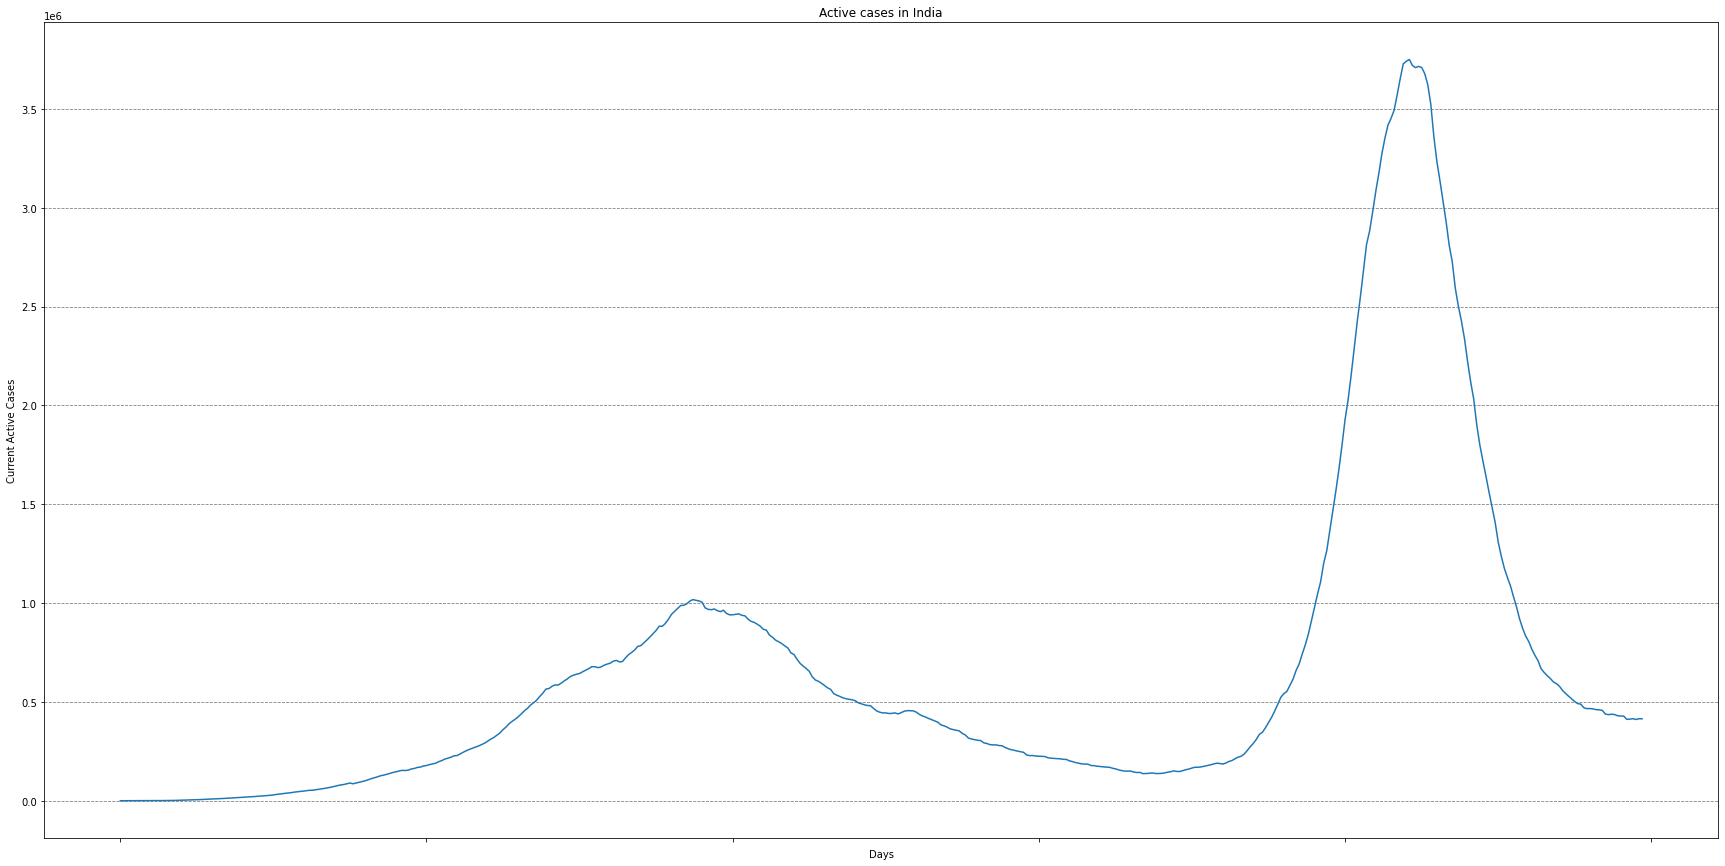

In [73]:
# Active cases in India

fig, ax = plt.subplots(1, 1, figsize=(30, 15))
ax.yaxis.grid(color="grey", linestyle="dashed")
g = sns.lineplot(data=active["TT"])
g.set(xticklabels=[])
g.set(title="Active cases in India")
g.set(xlabel="Days")
g.set(ylabel="Current Active Cases")
plt.show()

In [74]:
# Set window size

last_ndays = 30

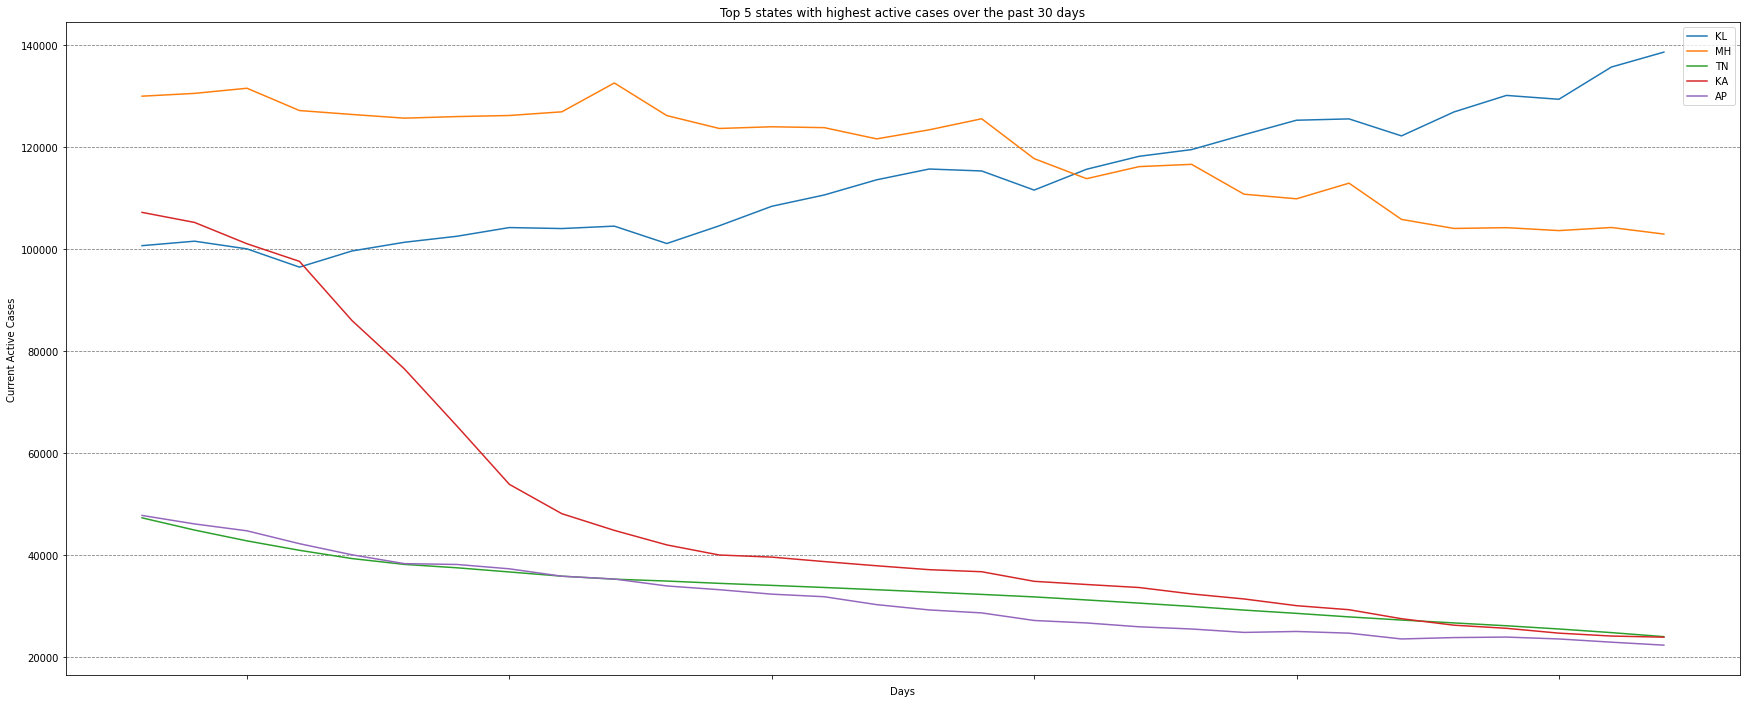

In [75]:
# Top 5 states with highest active cases

states = {}
for state in state_codes:
     states[state] = active.loc[len(active)-1][state]

states = dict(sorted(states.items(), key=lambda x: x[1], reverse=True)[:5]).keys()

fig, ax = plt.subplots(1, 1, figsize=(30, 12))
ax.yaxis.grid(color="grey", linestyle="dashed")
g = sns.lineplot(data=active[states][-last_ndays:], dashes=False)
g.set(xticklabels=[])
g.set(title="Top 5 states with highest active cases over the past " + str(last_ndays) + " days")
g.set(xlabel="Days")
g.set(ylabel="Current Active Cases")
plt.show()

In [76]:
# Segregate confirmed, recovered and deceased cases

confirmed = df.loc[df["Status"] == "Confirmed"]
recovered = df.loc[df["Status"] == "Recovered"]
deceased = df.loc[df["Status"] == "Deceased"]

display(confirmed)
display(recovered)
display(deceased)

,Date,Date_YMD,Status,TT,AN,AP,AR,AS,BR,CH,...,PB,RJ,SK,TN,TG,TR,UP,UT,WB,UN
0,14-Mar-20,2020-03-14,Confirmed,81,0,1,0,0,0,0,...,1,3,0,1,1,0,12,0,0,0
3,15-Mar-20,2020-03-15,Confirmed,27,0,0,0,0,0,0,...,0,1,0,0,2,0,1,0,0,0
6,16-Mar-20,2020-03-16,Confirmed,15,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
9,17-Mar-20,2020-03-17,Confirmed,11,0,0,0,0,0,0,...,0,0,0,0,1,0,2,0,1,0
12,18-Mar-20,2020-03-18,Confirmed,37,0,0,0,0,0,0,...,1,3,0,1,8,0,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1479,20-Jul-21,2021-07-20,Confirmed,42128,2,2498,476,1798,82,14,...,68,22,147,1904,657,488,69,50,752,0
1482,21-Jul-21,2021-07-21,Confirmed,41687,3,2527,418,1547,88,7,...,66,22,251,1891,691,457,52,37,869,0
1485,22-Jul-21,2021-07-22,Confirmed,34863,4,1843,486,1796,61,2,...,69,25,294,1872,648,253,52,56,793,0
1488,23-Jul-21,2021-07-23,Confirmed,39501,0,1747,480,1621,85,1,...,68,33,257,1830,643,509,57,11,842,0


,Date,Date_YMD,Status,TT,AN,AP,AR,AS,BR,CH,...,PB,RJ,SK,TN,TG,TR,UP,UT,WB,UN
1,14-Mar-20,2020-03-14,Recovered,9,0,0,0,0,0,0,...,0,1,0,0,0,0,4,0,0,0
4,15-Mar-20,2020-03-15,Recovered,4,0,0,0,0,0,0,...,0,2,0,0,1,0,0,0,0,0
7,16-Mar-20,2020-03-16,Recovered,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
10,17-Mar-20,2020-03-17,Recovered,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
13,18-Mar-20,2020-03-18,Recovered,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1480,20-Jul-21,2021-07-20,Recovered,36876,2,2201,404,1645,126,18,...,115,66,111,2439,704,410,155,33,992,0
1483,21-Jul-21,2021-07-21,Recovered,38891,4,2412,365,2426,129,8,...,94,55,96,2423,565,501,107,14,981,0
1486,22-Jul-21,2021-07-22,Recovered,38403,3,2199,468,2262,54,9,...,123,22,189,2475,696,259,56,48,966,0
1489,23-Jul-21,2021-07-23,Recovered,35144,2,2365,517,1869,100,2,...,105,66,179,2516,767,594,86,58,942,0


,Date,Date_YMD,Status,TT,AN,AP,AR,AS,BR,CH,...,PB,RJ,SK,TN,TG,TR,UP,UT,WB,UN
2,14-Mar-20,2020-03-14,Deceased,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,15-Mar-20,2020-03-15,Deceased,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,16-Mar-20,2020-03-16,Deceased,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,17-Mar-20,2020-03-17,Deceased,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,18-Mar-20,2020-03-18,Deceased,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1481,20-Jul-21,2021-07-20,Deceased,3998,0,24,0,10,2,0,...,7,0,1,30,2,1,9,0,10,0
1484,21-Jul-21,2021-07-21,Deceased,510,0,19,1,25,3,0,...,2,0,1,27,5,2,2,0,6,0
1487,22-Jul-21,2021-07-22,Deceased,481,0,12,4,22,0,0,...,4,1,2,29,3,1,4,2,13,0
1490,23-Jul-21,2021-07-23,Deceased,542,0,14,4,15,0,0,...,6,0,1,24,4,2,5,0,16,0


In [77]:
# Calculate total active, confirmed, recovered and deceased cases

print("Total Active Cases:", list(active["TT"])[-1])
print("Total Confirmed Cases:", confirmed["TT"].sum())
print("Total Recovered Cases:", recovered["TT"].sum())
print("Total Deceased Cases:", deceased["TT"].sum())

Total Active Cases: 414719
Total Confirmed Cases: 31370633
Total Recovered Cases: 30535325
Total Deceased Cases: 420589


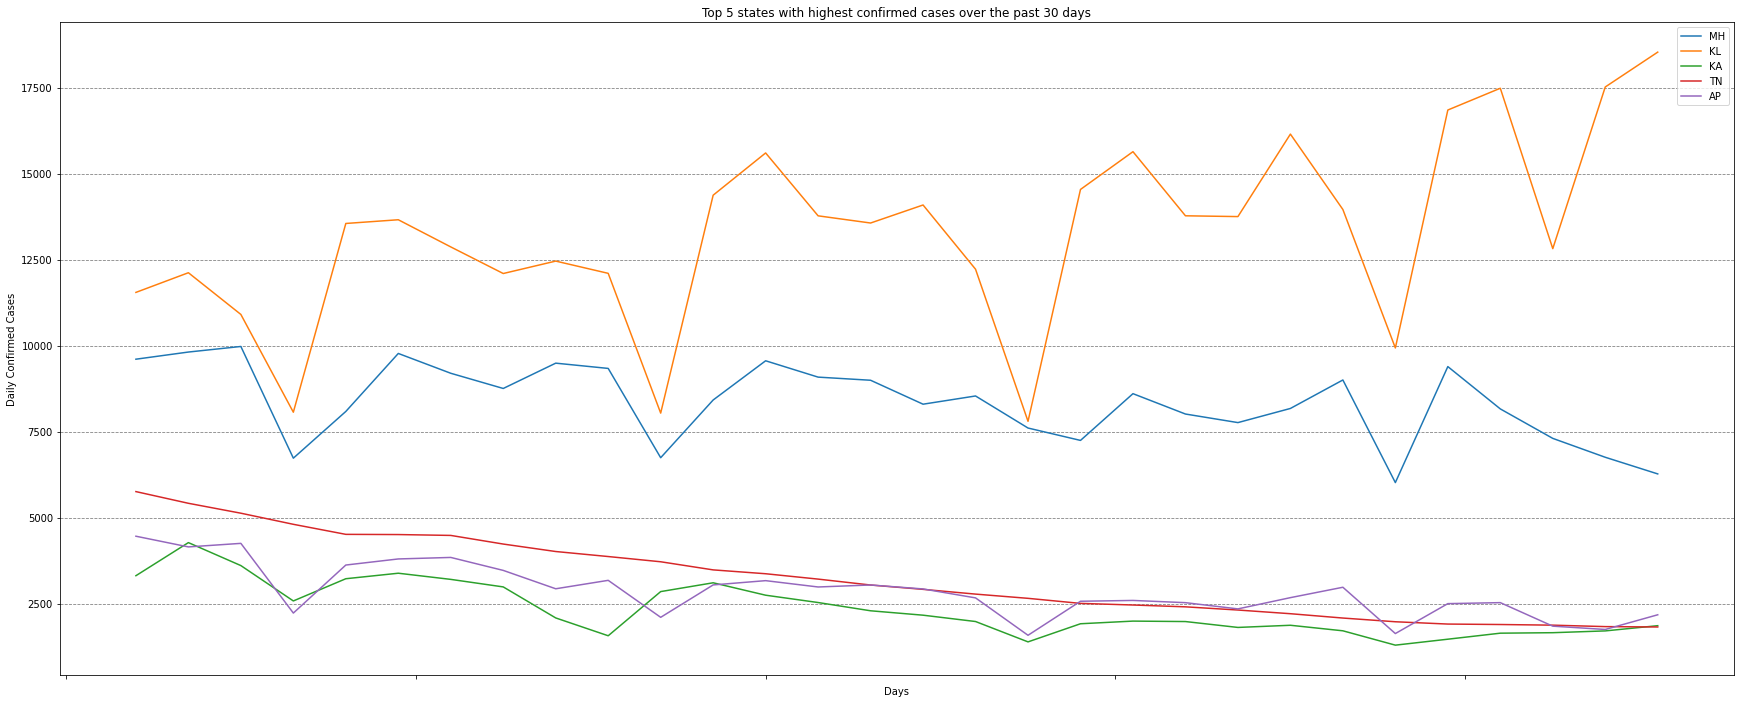

In [78]:
# Top 5 states with highest confirmed cases

states = {}
for state in state_codes:
     states[state] = confirmed[state].sum()

states = dict(sorted(states.items(), key=lambda x: x[1], reverse=True)[:5]).keys()

fig, ax = plt.subplots(1, 1, figsize=(30, 12))
ax.yaxis.grid(color="grey", linestyle="dashed")
g = sns.lineplot(data=confirmed[states][-last_ndays:], dashes=False)
g.set(xticklabels=[])
g.set(title="Top 5 states with highest confirmed cases over the past " + str(last_ndays) + " days")
g.set(xlabel="Days")
g.set(ylabel="Daily Confirmed Cases")
plt.show()

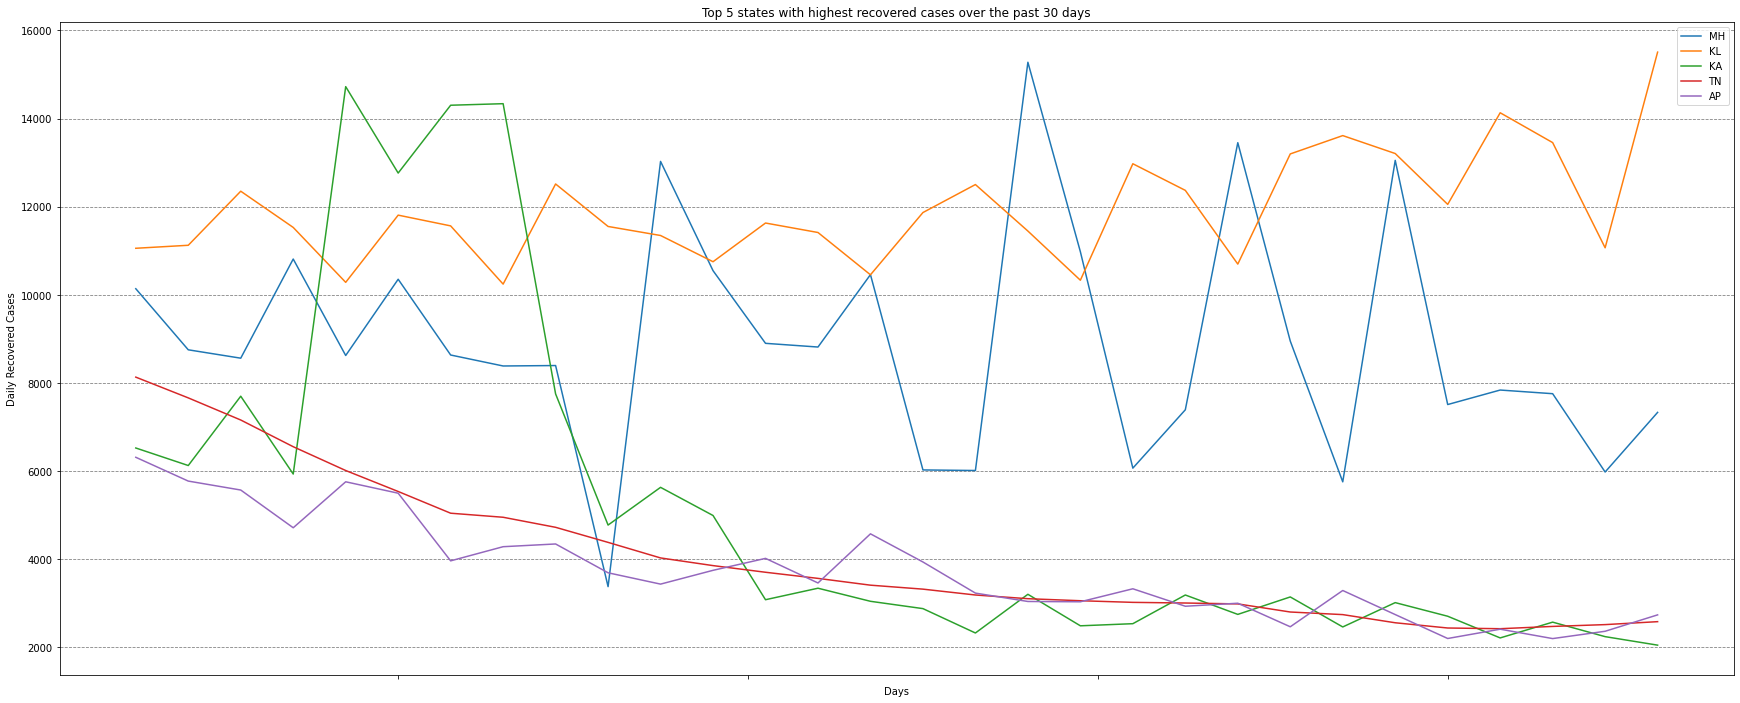

In [79]:
# Top 5 states with highest recovered cases

states = {}
for state in state_codes:
    states[state] = recovered[state].sum() 

states = dict(sorted(states.items(), key=lambda x: x[1], reverse=True)[:5]).keys()

fig, ax = plt.subplots(1, 1, figsize=(30, 12))
ax.yaxis.grid(color="grey", linestyle="dashed")
g = sns.lineplot(data=recovered[states][-last_ndays:], dashes=False)
g.set(xticklabels=[])
g.set(title="Top 5 states with highest recovered cases over the past " + str(last_ndays) + " days")
g.set(xlabel="Days")
g.set(ylabel="Daily Recovered Cases")
plt.show()

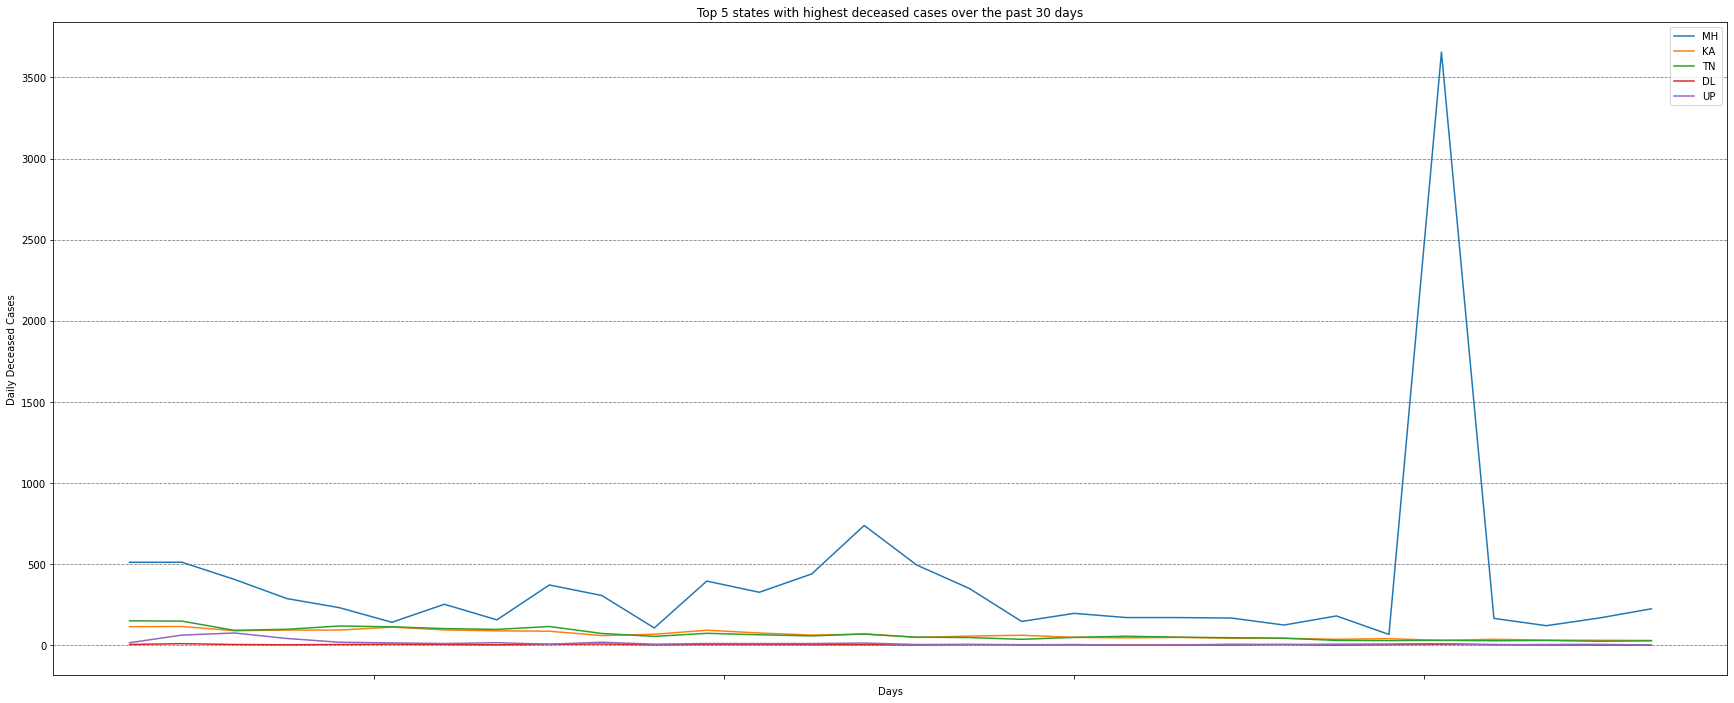

In [80]:
# Top 5 states with highest deceased cases

states = {}
for state in state_codes:
    states[state] = deceased[state].sum() 

states = dict(sorted(states.items(), key=lambda x: x[1], reverse=True)[:5]).keys()

fig, ax = plt.subplots(1, 1, figsize=(30, 12))
ax.yaxis.grid(color="grey", linestyle="dashed")
g = sns.lineplot(data=deceased[states][-last_ndays:], dashes=False)
g.set(xticklabels=[])
g.set(title="Top 5 states with highest deceased cases over the past " + str(last_ndays) + " days")
g.set(xlabel="Days")
g.set(ylabel="Daily Deceased Cases")
plt.show()

In [81]:
# Daily percentage contribution

daily_percentage = confirmed.copy()

for idx in range(len(daily_percentage)):
    daily_percentage.iloc[idx, 4:] = (daily_percentage.iloc[idx, 4:] / daily_percentage.iloc[idx, 3]) * 100

daily_percentage.drop(columns=["Date", "Status", "TT", "UN"], inplace=True)
display(daily_percentage)

,Date_YMD,AN,AP,AR,AS,BR,CH,CT,DN,DD,...,PY,PB,RJ,SK,TN,TG,TR,UP,UT,WB
0,2020-03-14,0.000000,1.234568,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,1.234568,3.703704,0.000000,1.234568,1.234568,0.000000,14.814815,0.000000,0.000000
3,2020-03-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,3.703704,0.000000,0.000000,7.407407,0.000000,3.703704,0.000000,0.000000
6,2020-03-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,6.666667,0.000000,0.000000,0.000000,0.000000,6.666667,0.000000,0.000000,6.666667,0.000000
9,2020-03-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,9.090909,0.000000,18.181818,0.000000,9.090909
12,2020-03-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,2.702703,8.108108,0.000000,2.702703,21.621622,0.000000,5.405405,2.702703,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1479,2021-07-20,0.004747,5.929548,1.129890,4.267945,0.194645,0.033232,0.448633,0.018990,0.0,...,0.185150,0.161413,0.052222,0.348937,4.519559,1.559533,1.158374,0.163787,0.118686,1.785036
1482,2021-07-21,0.007196,6.061842,1.002711,3.710989,0.211097,0.016792,0.450980,0.016792,0.0,...,0.268669,0.158323,0.052774,0.602106,4.536186,1.657591,1.096265,0.124739,0.088757,2.084583
1485,2021-07-22,0.011473,5.286407,1.394028,5.151593,0.174971,0.005737,0.622436,0.011473,0.0,...,0.195049,0.197918,0.071709,0.843301,5.369590,1.858704,0.725698,0.149155,0.160629,2.274618
1488,2021-07-23,0.000000,4.422673,1.215159,4.103694,0.215184,0.002532,0.298727,0.015189,0.0,...,0.248095,0.172148,0.083542,0.650616,4.632794,1.627807,1.288575,0.144300,0.027847,2.131592


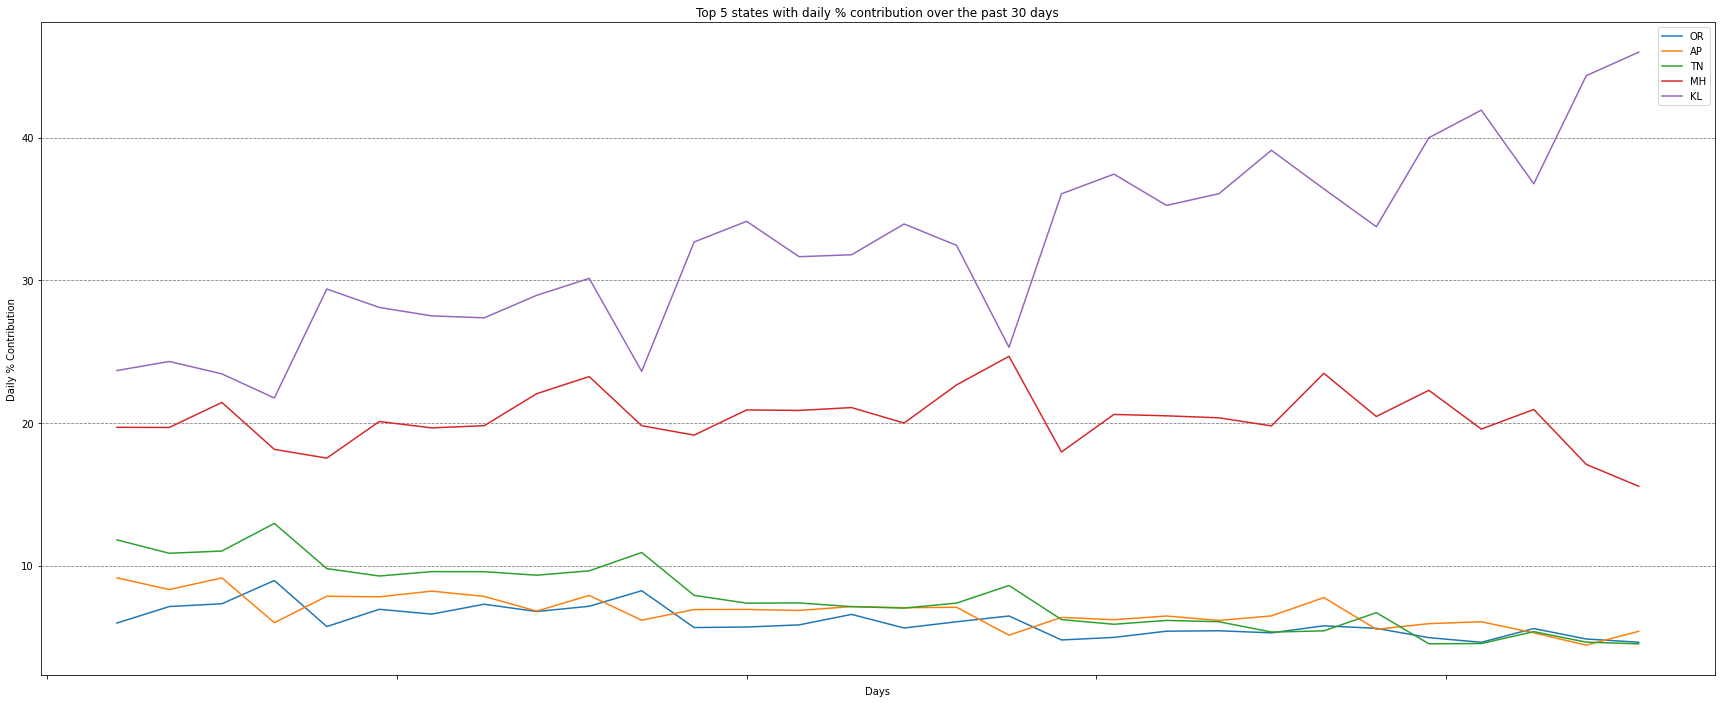

In [82]:
# Top 5 daily contributing states

daily_mean = dict.fromkeys(state_codes, 0)
for state in state_codes:
    daily_mean[state] = daily_percentage[state][-last_ndays:].mean()

top_five_daily = dict(sorted(daily_mean.items(), key=lambda item: item[1]))
top_five_daily = list(top_five_daily.keys())[-5:]

fig, ax = plt.subplots(1, 1, figsize=(30, 12))
ax.yaxis.grid(color="grey", linestyle="dashed")
g = sns.lineplot(data=daily_percentage[top_five_daily][-last_ndays:], dashes=False)
g.set(xticklabels=[])
g.set(title="Top 5 states with daily % contribution over the past " + str(last_ndays) + " days")
g.set(xlabel="Days")
g.set(ylabel="Daily % Contribution")
plt.show()

If you found this notebook helpful please give a thumbs up!